In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_KERAS"] = "1"

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0


sample_num = 60

In [2]:
root_path = '..//../data/'
train = pd.read_csv(root_path+'sensor_train.csv')
test = pd.read_csv(root_path+'sensor_test.csv')
sub = pd.read_csv(root_path+'提交结果示例.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
#     df['thetax']=np.arctan(df.acc_xg/
#                            np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
#     df['thetay']=np.arctan(df.acc_yg/
#                            np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
#     df['thetaz']=np.arctan(df.acc_zg/
#                            np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi

#     df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
#     df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5    
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df


train=add_features(train)
test=add_features(test)

group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
# group1 = ["acc_x","acc_y","acc_z","acc","acc_xg","acc_yg","acc_zg","accg"]


test['fragment_id'] += 10000
data = pd.concat([train, test], sort=False)
ss_tool = StandardScaler()
data[group1] = ss_tool.fit_transform(data[group1])


train = data[data["behavior_id"].isna()==False].reset_index(drop=True)
test = data[data["behavior_id"].isna()==True].reset_index(drop=True)
test['fragment_id'] -= 10000
print(test.shape)



x = np.zeros((7292, sample_num, len(group1), 1))
t = np.zeros((7500, sample_num, len(group1), 1))
print(x.shape)


Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'accg', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'accg', 'g'],
      dtype='object')
(430182, 12)
(7292, 60, 9, 1)


In [3]:

train = train[['fragment_id', 'time_point', 'behavior_id']+group1]
test = test[['fragment_id', 'time_point']+group1]
print(train.columns)

for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_num]
    x[i,:,:,0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1)[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,len(group1))
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_num]
    t[i,:,:,0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1)[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,len(group1))

    
    

  1%|          | 47/7292 [00:00<00:15, 467.18it/s]

Index(['fragment_id', 'time_point', 'behavior_id', 'acc_x', 'acc_y', 'acc_z',
       'acc_xg', 'acc_yg', 'acc_zg', 'acc', 'accg', 'g'],
      dtype='object')


100%|██████████| 7500/7500 [00:15<00:00, 492.55it/s]


In [4]:
def ConvBNRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
#                activation='relu',
               use_bias=False,
               padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X


def ConvRelu(X,filters,kernal_size=(3,3)):
    X = Conv2D(filters=filters,
               kernel_size=kernal_size,
               activation='relu',
               use_bias=False,
               padding='same')(X)
    return X


def squeeze_excitation_layer(x, out_dim,ratio=8):
    '''
    SE module performs inter-channel weighting.
    '''
    squeeze = GlobalAveragePooling2D()(x)

    excitation = Dense(units=out_dim // ratio)(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Dense(units=out_dim)(excitation)
    excitation = Activation('sigmoid')(excitation)
    excitation = Reshape((1,1,out_dim))(excitation)
    scale = multiply([x,excitation])
    return scale


def lenet5(input):
    X = ConvBNRelu(input,64)
#     X = squeeze_excitation_layer(X,64)
    X = ConvBNRelu(X,128)
    X = Dropout(0.2)(X)
#     X = squeeze_excitation_layer(X,128)
    X = MaxPooling2D()(X)
    
    X = ConvBNRelu(X,256)
    X = Dropout(0.3)(X)
    X = squeeze_excitation_layer(X,256)
    X = ConvBNRelu(X,512)   
    X = Dropout(0.5)(X)
#     X = squeeze_excitation_layer(X,512)
    X = GlobalMaxPooling2D()(X)
#     X = BatchNormalization()(X)
    return X
    
def Net():
    input1 = Input(shape=(sample_num, 8, 1))
    X = lenet5(input1)
    O = Dense(19,)(X)
#     O = Dense(19, activation='softmax')(X)
    return Model([input1], O)

from keras_self_attention import SeqSelfAttention
def LSTM_A(input,INPUT_SIZE = 8,CELL_SIZE = 64):
    TIME_STEPS = 60
    OUTPUT_SIZE = 19
    
    activateion_fun = 'tanh'
#     inputs = Input(shape=[TIME_STEPS,INPUT_SIZE])
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,INPUT_SIZE), return_sequences=True, activation=activateion_fun)(input)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True,activation=activateion_fun)(x)
    x = LayerNormalization()(x)
#     x = Attention()([x,x])
    x = Dropout(0.3)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True)(x)
    x = Attention()([x,x])
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)   
    return x

def LSTM_B(input,INPUT_SIZE = 8):
    TIME_STEPS = 60
    OUTPUT_SIZE = 19
    CELL_SIZE = 128
    activateion_fun = 'tanh'
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,INPUT_SIZE), return_sequences=True, activation=activateion_fun)(input)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(CELL_SIZE*2, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True,activation=activateion_fun)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE*2), return_sequences=False)(x)
    x = LayerNormalization()(x) 
    return x

def LSTM_C(input,INPUT_SIZE = 8):
    TIME_STEPS = 60
    INPUT_SIZE = 8
    OUTPUT_SIZE = 19
    CELL_SIZE = 64
    activateion_fun = 'tanh'
#     inputs = Input(shape=[TIME_STEPS,INPUT_SIZE])
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,INPUT_SIZE), return_sequences=True, activation=activateion_fun)(input)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,INPUT_SIZE), return_sequences=True, activation=activateion_fun)(input)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(CELL_SIZE*2, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True,activation=activateion_fun)(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE*2), return_sequences=False)(x)
    x = LayerNormalization()(x) 
    return x
import tensorflow as tf
def LSTM_Model():
    
    TIME_STEPS = 60
    INPUT_SIZE = len(group1)
    OUTPUT_SIZE = 19
    activateion_fun = 'tanh'
    inputs = Input(shape=[TIME_STEPS,INPUT_SIZE])
    part = tf.split(inputs,axis=2, num_or_size_splits = [3,3,1,1,1])
    A = LSTM_A(inputs,CELL_SIZE = 32)
    A1 = LSTM_A(part[0],3,CELL_SIZE = 16)
    A2 = LSTM_A(part[1],3,CELL_SIZE = 16)
    A3 = LSTM_A(Concatenate()([part[2],part[3],part[4]]),3,CELL_SIZE = 16)
    A4 = LSTM_A(Concatenate()([part[0],part[2]]),4,CELL_SIZE = 32)
    A5 = LSTM_A(Concatenate()([part[1],part[3]]),4,CELL_SIZE = 32)
    
#     A4 = LSTM_A(part[3],6,CELL_SIZE = 16)    
#     B = LSTM_B(inputs,INPUT_SIZE=9)
#     C = LSTM_C(inputs,CELL_SIZE=46)
    x = Concatenate()([A,A1,A2,A3,A4,A5])
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    X = BatchNormalization()(x)
    output1 = Dense(4, activation='softmax', name='4class')(X)   # 大类-字母
    print(X.shape)
#     output2 = Dense(128)(X)
#     output2 = Dense(64)(X)
    X = Dense(64)(X)
    output2 = Dense(7, activation='softmax', name='7class')(X)   # 大类-数字
#     X = Dense(64)(X)
#     X = Dense(32)(X)
#     X = Concatenate(axis=-1)([X,output1,output2])
    X = Dense(64)(X)
    output3 = Dense(19, activation='softmax',name='19class')(X) #小类
    print(output3.shape)
    return Model([inputs], [output1,output2,output3])

LSTM_Model().summary()

(None, 256)
(None, 19)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 9)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 60, 3), (Non 0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 3)        0           tf_op_layer_split[0][2]          
                                                                 tf_op_layer_split[0][3]          
                                                                 tf_op_layer_split[0][4]          
_______________________________________________________________________

In [6]:
mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
from sklearn.utils.class_weight import compute_class_weight
# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights1=compute_class_weight("balanced",['A','B','C','D'],\
                                   pd.read_csv(root_path+'sensor_train.csv')['behavior_id'].apply(lambda x:mapping[x][0]))
classweights1=pd.DataFrame(classweights1)[0].to_dict()
classweights1
classweights2=compute_class_weight("balanced",list(range(7)),\
                                   pd.read_csv(root_path+'sensor_train.csv')['behavior_id'].apply(lambda x:int(mapping[x][2])))
classweights2=pd.DataFrame(classweights2)[0].to_dict()
classweights2
from sklearn.utils.class_weight import compute_class_weight
# y_train_weight = compute_sample_weight("balanced", train['behavior_id'])
classweights3=compute_class_weight("balanced",np.array(range(19)), pd.read_csv(root_path+'sensor_train.csv')['behavior_id'])
classweights3=pd.DataFrame(classweights3)[0].to_dict()

In [8]:
classweights1.keys()

dict_keys([0, 1, 2, 3])

In [19]:
# [:,:,:,[1]]
train = x
test = t

    
fold_num=5
kfold = StratifiedKFold(fold_num,random_state=42,shuffle=True)
proba_t = np.zeros((7500, 19))
proba_oof = np.zeros((7292,19))

oof_score = []
oof_comm = []
history = []

from tensorflow.keras.losses import categorical_crossentropy
def custom_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# 两个输出    
mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
16: 'C_2', 17: 'C_5', 18: 'C_6'}
# 每一个大类输出 4
new_mapping = {'A':0,'B':1,'C':2,'D':3}
y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=4)
# 每一个大类输出 
new_mapping = {'A':0,'B':1,'C':2,'D':3}
y_2 = to_categorical([mapping[x][2] for x in y], num_classes=7)
# 每一个小类的输出 19
y_3 = to_categorical(y, num_classes=19)


for fold, (xx, yy) in enumerate(kfold.split(train, y)):

    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
    4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
    8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
    12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
    16: 'C_2', 17: 'C_5', 18: 'C_6'}
    new_mapping = {'A':0,'B':1,'C':2,'D':3}
    
    model = LSTM_Model()
    model.summary()
    model.compile(loss=[custom_loss,custom_loss,custom_loss],loss_weights=[3,7,21],
                  optimizer=Adam(),
                  metrics=["acc"])#'',localscore
    plateau = ReduceLROnPlateau(monitor="19class_acc",
                                verbose=1,
                                mode='max',
                                factor=0.7,
                                patience=18)
    early_stopping = EarlyStopping(monitor="val_19class_acc",
                                   verbose=1,
                                   mode='max',
                                   patience=60)
#     file_path = save_dir + f'/fold{fold}' + '_weights_{epoch:02d}_{val_loss:.2f}_{val_acc:.2f}.h5'
#     checkpoint = ModelCheckpoint(file_path,
#                     monitor='val_acc',
#                     verbose=1,
#                     mode='max',
#                     save_best_only=False)    # 保存所有的
    checkpoint = ModelCheckpoint(f'Conv2d_multiloss_fold{fold}.h5',
                                 monitor="val_19class_acc",
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
 
    train_res = model.fit(train[xx][:,:,:,0], [y_1[xx], y_2[xx], y_3[xx]],
              epochs=400,
              batch_size=32,
              verbose=1,
              shuffle=True,
              validation_data=(train[yy][:,:,:,0], [y_1[yy], y_2[yy],y_3[yy]]),
              callbacks=[plateau, early_stopping,checkpoint],
              class_weight=[classweights1,classweights2,classweights3])
    history.append(train_res)
    
    
#     # 找到对应最高的 val_acc 对应的epoch，预测left+1+right次
#     left=2
#     right=2
#     max_acc_index=history[fold].history['val_acc'].index(np.max(history[fold].history['val_acc']))+1

#     save_filelist=os.listdir(save_dir)
#     save_filelist.sort()
#     select_blending=save_filelist[max_acc_index-left : max_acc_index+right]
#     print(select_blending)
#     for file in select_blending:
#         model.load_weights(save_dir+'/'+file)
#         proba_t += model.predict(t, verbose=0, batch_size=1024) / (fold_num*len(select_blending))
#         proba_oof[yy] = model.predict(train[yy],verbose=0,batch_size=1024) / len(select_blending)
    
    model.load_weights(f'Conv2d_multiloss_fold{fold}.h5')
    proba_t += model.predict(test[:,:,:,0], verbose=0, batch_size=1024)[2] / fold_num 
    proba_oof[yy] += model.predict(train[yy][:,:,:,0],verbose=0,batch_size=1024) [2]

    oof_y = np.argmax(proba_oof[yy], axis=1)
    acc = round(accuracy_score(y[yy], oof_y),3)
    print(acc)
    oof_score.append(acc)
    scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
    oof_comm.append(scores)   
    print(round(scores, 5))


(None, 256)
(None, 19)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 60, 9)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_split_12 (TensorFlo [(None, 60, 3), (Non 0           input_13[0][0]                   
__________________________________________________________________________________________________
concatenate_48 (Concatenate)    (None, 60, 3)        0           tf_op_layer_split_12[0][2]       
                                                                 tf_op_layer_split_12[0][3]       
                                                                 tf_op_layer_split_12[0][4]       
____________________________________________________________________

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

    
oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
# joblib.dump(oof_dict,"lstm_mutiloss_4sub_bs32.pkl")
    
print(oof_score)
print(oof_comm)


0 0.8549234635595138 0.83
1 0.833251737981003 0.805
2 0.8414984649552534 0.815
3 0.8417597491671552 0.813
4 0.8651120256058513 0.842
[0.83, 0.805, 0.815, 0.813, 0.842]
[0.8549234635595138, 0.833251737981003, 0.8414984649552534, 0.8417597491671552, 0.8651120256058513]


In [ ]:
'''lstm baseline
0 0.7871666829857358 0.754
1 0.7745357224452475 0.738
2 0.7666078777189876 0.724
3 0.7799660330524517 0.74
4 0.784669148866678 0.747
'''
'''lstm_NB_layerNorm_AvePooling
0 0.7825647051143947 0.746
1 0.7841966121609696 0.751
2 0.788490430465738 0.754
3 0.7902867594225609 0.752
4 0.8051472989744576 0.773
'''
'''去掉双向
0 0.7993733476941134 0.768
1 0.7980025457749909 0.764
2 0.8037428963354872 0.77
3 0.7997256515775022 0.767
4 0.802730420014369 0.77
'''
'''more wide
0 0.8240477822383224 0.796
1 0.8095564476647393 0.776
2 0.8125938990136501 0.783
3 0.7985825331504338 0.763
4 0.8233718727545867 0.794
'''
'''split channels
0 0.8186624889846258 0.79
1 0.8136362152811761 0.781
2 0.8075315174080595 0.778
3 0.7980926252531181 0.767
4 0.8239271017048774 0.796

'''
'''add attention
0 0.8186951271255575 0.79
1 0.7945102646953215 0.761
2 0.8192566464171388 0.789
3 0.8061924358220645 0.77
4 0.8307531517408047 0.803

'''
'''调整dropout及训练策略，reduceonplateau 

0 0.8272789581905398 0.802
1 0.8231991905741032 0.796
2 0.823829120125415 0.794
3 0.8362401201907365 0.808
4 0.840583970213598 0.814

'''

'''lstm_NB_4sub_bs32
0 0.843369561669766 0.819
1 0.8388002219393567 0.808
2 0.8508393755307321 0.824
3 0.8372852570383419 0.81
4 0.8516885492194121 0.826

'''

0.82488
0.85112


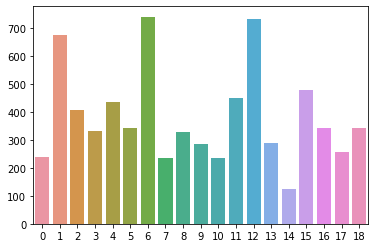

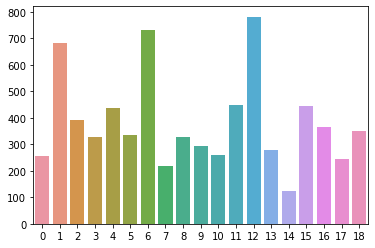

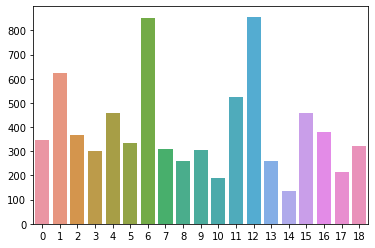

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  7500 non-null   int64
 1   behavior_id  7500 non-null   int64
dtypes: int64(2)
memory usage: 117.3 KB


In [18]:
# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t, axis=1)
oof_y = np.argmax(proba_oof, axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../../data/'
sub = pd.read_csv(data_path+'提交结果示例.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
# sns.barplot(vc.index, vc.values)
# plt.show()
sub.to_csv('lstm%.5f.csv' % scores, index=False)
sub.info()
